# Generation Classification with a Convolutional Neural Network

In [1]:
import os
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from PIL import ImageFile
from collections import Counter
import pandas as pd

ImageFile.LOAD_TRUNCATED_IMAGES = True
%matplotlib inline

# custom modules
from models.multibranch_cnn import MultiBranchGenClassifier
from models.cnn import GenClassifier
from models.model_metrics import plot_metrics, get_num_params
from custom_dataset import ModelDataset

## Create Dataset

Defines labels in accordance with https://www.beresfordresearch.com/age-range-by-generation/ and assigns a label to each category.

Splits the data into training/validation and test sets.

In [2]:
def generation_dict():
    """
    Defines and returns the generations and class labels.

    Returns:
        dict: Dictionary of labels and classes. 
    """
    classes = {
        'Gen Alpha': 0,
        'Gen Z': 1,
        'Millenial': 2,
        'Gen X': 3,
        'Baby Boomer': 4,
        'Post War': 5,
        'WWII': 6
    }
    return classes

def get_label(age):
    generations = generation_dict()
    """
    Assigns an age to a label
    
    Args:
        age (int): The age of the subject.

    Returns:
        int: Label
    """
    if 0 <= age <= 11:
        return generations['Gen Alpha']
    elif 12 <= age <= 26:
        return generations['Gen Z']
    elif 27 <= age <= 42:
        return generations['Millenial']
    elif 43 <= age <= 58:
        return generations['Gen X']
    elif 59 <= age <= 77:
        return generations['Baby Boomer']
    elif 78 <= age <= 95:
        return generations['Post War']
    else:
        return generations['WWII']

def split_data(data, shuffle=True):
    """
    Extracts label/image pairs from the total data and creates 
        training, validation and testing sets.
    Labels for each person are embedded in file names
    [age]_[gender]_[race]_[date&time].jpg

    Args:
        data (str): File path to the folder containing all the images.

    Returns:
        train, val, test (list, list, list): training, validation and
            testing sets.
    """
    # Gets full file name
    file = [file_name for file_name in os.listdir(data) if 
              file_name.endswith('.jpg')]
    # Extracts subject age from the file name
    label = [get_label(int(label.split('_')[0])) for label in file]
    # Pairs labels with images
    dataset = zip(label, file)
    dataset = list(dataset)
    if shuffle:
        random.shuffle(dataset)
    
    split_80 = int(len(dataset)*0.8)
    split_10 = int((len(dataset)-split_80)/2)
    # first 80% of data is for training
    train = dataset[: split_80]
    # next 10% for validation
    val = dataset[split_80 : split_80 + split_10]
    # final 10% for testing
    test = dataset[split_80 + split_10 : (split_80 + (split_10*2))]
    return train, val, test

def dataset_details(dataset, set_name):
    """
    Displays the number of elements each class has in the dataset.

    Args:
        dataset (DataFrame): 
        set_name (str): Name of the dataset (e.g. 'Training').
    """
    dataset = pd.DataFrame(dataset, columns=['label', 'image'])
    num_samples = len(dataset)
    class_dict = Counter(dataset['label'].tolist())
    # Count members of each class
    num_gen_alpha = class_dict[0]
    num_gen_z = class_dict[1]
    num_millenial = class_dict[2]
    num_gen_x = class_dict[3]
    num_boomer = class_dict[4]
    num_post_war = class_dict[5]
    num_wwii = class_dict[6]
    

    print('*' + '-' * 20 + '*')
    print(f'|     {set_name:11}    |')
    print('|' + '-' * 20 + '|')
    print(f'| Samples : {num_samples:7}  |')
    print('*' + '-' * 20 + '*')
    print(f'| Gen Alpha : {num_gen_alpha:6} |')
    print(f'| Gen Z     : {num_gen_z:6} |')
    print(f'| Millenial : {num_millenial:6} |')
    print(f'| Gen X     : {num_gen_x:6} |')
    print(f'| Boomer    : {num_boomer:6} |')
    print(f'| Post War  : {num_post_war:6} |')
    print(f'| WWII      : {num_wwii:6} |')
    print('*' + '-' * 20 + '*')
    if set_name == 'Testing':
        print('\n\n')

In [3]:
file_path = 'Data/Faces Grouped'
train, val, test = split_data(file_path)

dataset_details(train, 'Training')
dataset_details(val, 'Validation')
dataset_details(test, 'Testing')

*--------------------*
|     Training       |
|--------------------|
| Samples :   19284  |
*--------------------*
| Gen Alpha :   2819 |
| Gen Z     :   5274 |
| Millenial :   6058 |
| Gen X     :   2852 |
| Boomer    :   1633 |
| Post War  :    600 |
| WWII      :     48 |
*--------------------*
*--------------------*
|     Validation     |
|--------------------|
| Samples :    2411  |
*--------------------*
| Gen Alpha :    363 |
| Gen Z     :    649 |
| Millenial :    781 |
| Gen X     :    351 |
| Boomer    :    192 |
| Post War  :     69 |
| WWII      :      6 |
*--------------------*
*--------------------*
|     Testing        |
|--------------------|
| Samples :    2411  |
*--------------------*
| Gen Alpha :    375 |
| Gen Z     :    667 |
| Millenial :    738 |
| Gen X     :    348 |
| Boomer    :    213 |
| Post War  :     64 |
| WWII      :      6 |
*--------------------*





## Overload PyTorch Dataset

Overloading the Dataset class enables rewriting of the `__getitem__()` function. This is how the DataLoader is able to retrieve three, differently transformed, images as well as the label when collecting the data for each batch.

## Define Transforms and Create Datasets

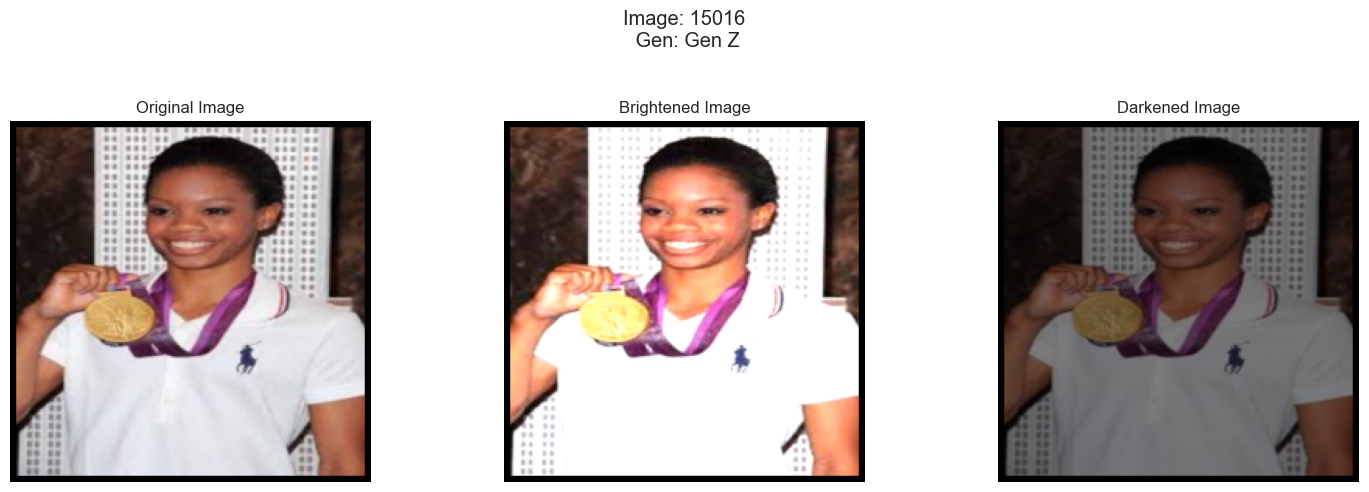

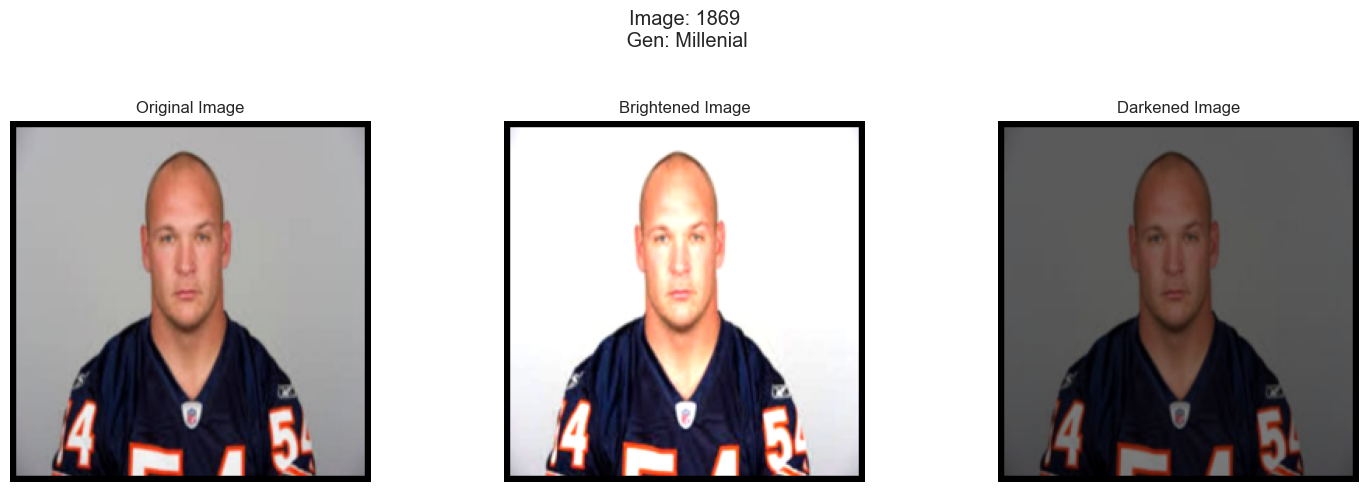

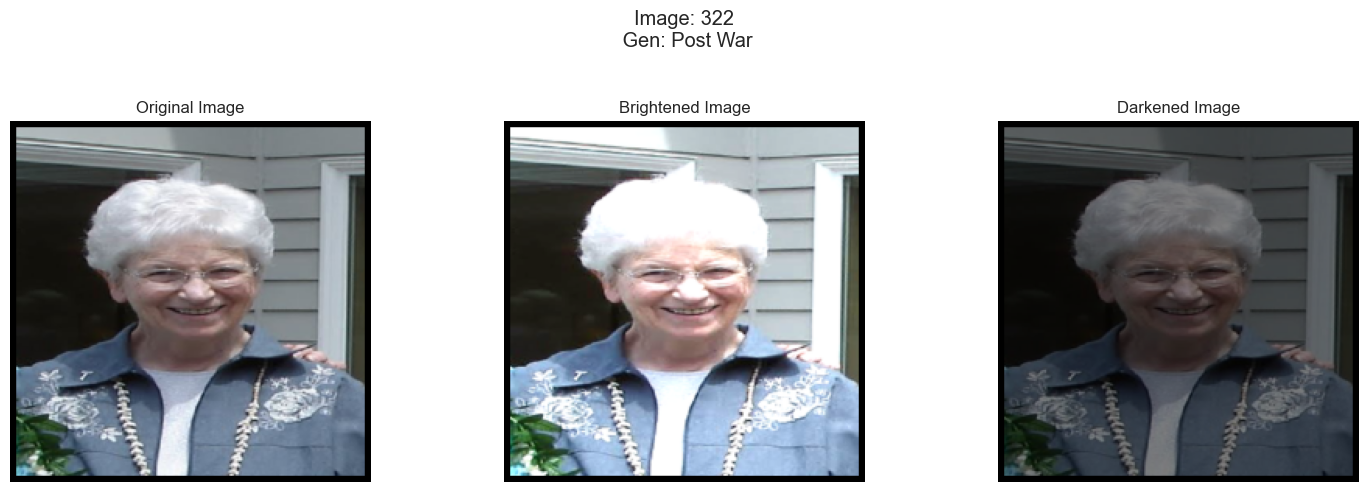

In [11]:
# Create datasets
train_data = ModelDataset(train)
val_data = ModelDataset(val)
test_data = ModelDataset(test)

def show_image(data: Dataset):
    AGE_TO_INT = {
        'Gen Alpha': 0,
        'Gen Z': 1,
        'Millenial': 2,
        'Gen X': 3,
        'Baby Boomer': 4,
        'Post War': 5,
        'WWII': 6
    }
    """
    Displays the label and set of images from a random sample.

    Args:
        data (Dataset): Dataset to select random sample from.
    """
    def denormalize(image):
        """
        Reverses the normalisation applied to the image.

        Args:
            image (torch.Tensor): Tensor representing the image.

        Returns:
            (torch.Tensor): _description_
        """
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        return image * std + mean
    
    idx = random.randint(0, len(data))
    label, image, b_image, d_image = data.__getitem__(idx)
    image_denorm = denormalize(image)
    b_image_denorm = denormalize(b_image)
    d_image_denorm = denormalize(d_image)

    keys = list(AGE_TO_INT.keys())
    gen = keys[label]

    title = f'Image: {idx}\n Gen: {gen}\n\n'
    fig, axs = plt.subplots(1, 3, figsize=(15,5))
    axs[0].imshow(image_denorm.permute(1,2,0))
    axs[0].axis('off')
    axs[0].set_title('Original Image')
    axs[1].imshow(b_image_denorm.permute(1,2,0))
    axs[1].axis('off')
    axs[1].set_title('Brightened Image')
    axs[2].imshow(d_image_denorm.permute(1,2,0))
    axs[2].axis('off')
    axs[2].set_title('Darkened Image')
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

show_image(train_data)
show_image(val_data)
show_image(test_data)

In [5]:
def set_device():
    """
    Device used to process tensors.
    """
    if torch.backends.mps.is_available():
        if torch.backends.mps.is_built():
            print('Using MPS')
            return torch.device("mps")
    else:
        return torch.device("cpu")

    
device = set_device()

Using MPS


# Run CNN

In [6]:
model = GenClassifier()
model = model.to(device, dtype=torch.float32)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, verbose=False)

print("{:,} trainable parameters.".format(get_num_params(model)))

17,695 trainable parameters.


In [7]:
batch_size = 64

batch_size = 64
train_loader = DataLoader(train_data, batch_size, shuffle=True, num_workers=5)
val_loader = DataLoader(val_data, batch_size, shuffle=True, num_workers=5)
test_loader = DataLoader(test_data, batch_size, shuffle=True, num_workers=5)

epochs = 1

model_attributes = {
    'criterion': criterion,
    'scheduler': scheduler,
    'batch_size': batch_size,
    'scheduler': scheduler
}

t_acc, t_loss, v_acc, v_loss = model.run_training(
    train_loader,
    val_loader,
    test_loader,
    optimizer,
    scheduler,
    criterion,
    device,
    epochs,
)

-------------------------------------------------
|		     Epoch 1      		|
-------------------------------------------------


|    76 /   302 batches | 33.17775974% accurate |
|   152 /   302 batches | 33.59885621% accurate |
|   228 /   302 batches | 33.76774017% accurate |
-------------------------------------------------
| Validation Accuracy   : 34.46702613% accurate |
-------------------------------------------------
| Time Elapsed		: 136.17 seconds	|
-------------------------------------------------

*-----------------------------------------------*
*		Evaluating Test Data		*
*-----------------------------------------------*
* Test Accuracy		: 35.66984654% accurate *
* Total Training Time	: 2.87 minutes  	*
*-----------------------------------------------*


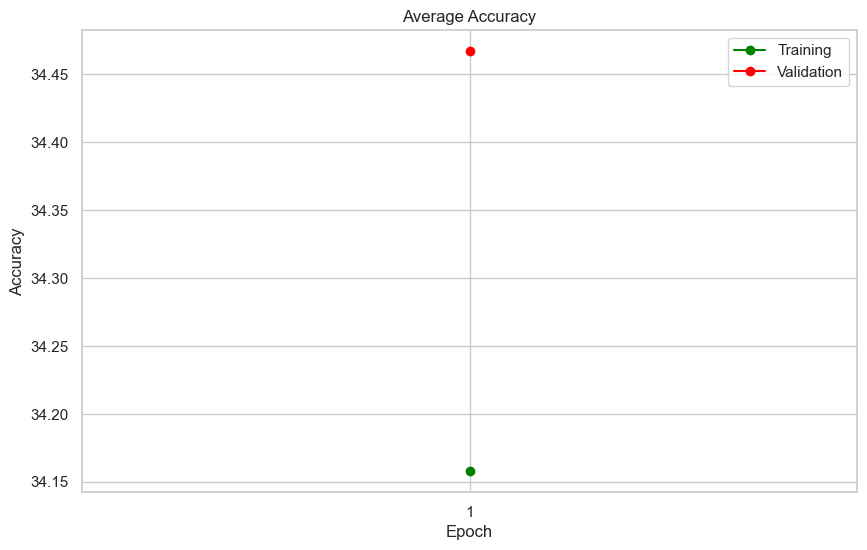

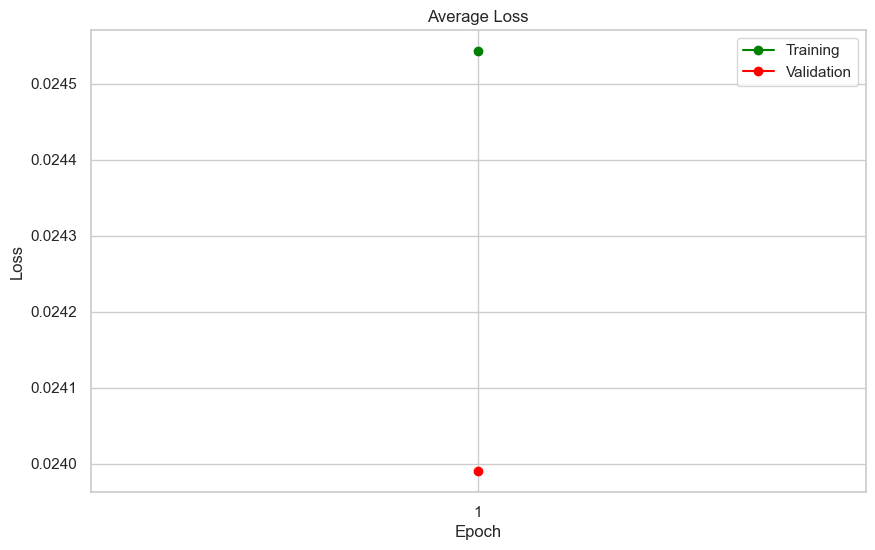

In [8]:
plot_metrics(t_acc, v_acc, 'Accuracy')
plot_metrics(t_loss, v_loss, 'Loss')

# Run Multi-Branch Model

In [7]:
"""
Initialise multi-branch model
"""

mb_model = MultiBranchGenClassifier().to(device, dtype=torch.float32)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mb_model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, verbose=False)

print("{:,} trainable parameters.".format(get_num_params(mb_model)))

Adjusting learning rate of group 0 to 1.0000e-02.
106,275 trainable parameters.


In [8]:
batch_size = 64
train_loader = DataLoader(train_data, batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size, shuffle=True)

epochs = 1

model_attributes = {
    'criterion': criterion,
    'scheduler': scheduler,
    'batch_size': batch_size,
    'scheduler': scheduler
}

t_acc, t_loss, v_acc, v_loss = mb_model.run_training(
    train_loader,
    val_loader,
    test_loader,
    optimizer,
    scheduler,
    criterion,
    device,
    epochs,
)

-------------------------------------------------
|		     Epoch 1      		|
-------------------------------------------------
|    38 /   151 batches | 33.23317308% accurate |
|    76 /   151 batches | 33.24878247% accurate |
|   114 /   151 batches | 33.81793478% accurate |
Adjusting learning rate of group 0 to 1.0000e-02.
-------------------------------------------------
| Validation Accuracy   : 34.67440896% accurate |
-------------------------------------------------
| Time Elapsed		: 510.56 seconds	|
-------------------------------------------------

*-----------------------------------------------*
*		Evaluating Test Data		*
*-----------------------------------------------*
* Test Accuracy		: 34.25964330% accurate *
* Total Training Time	: 9.22 minutes  	*
*-----------------------------------------------*


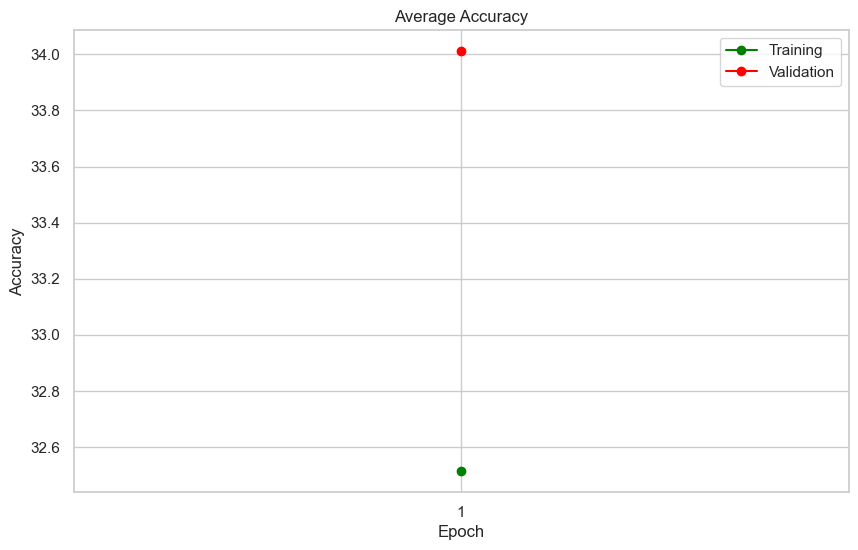

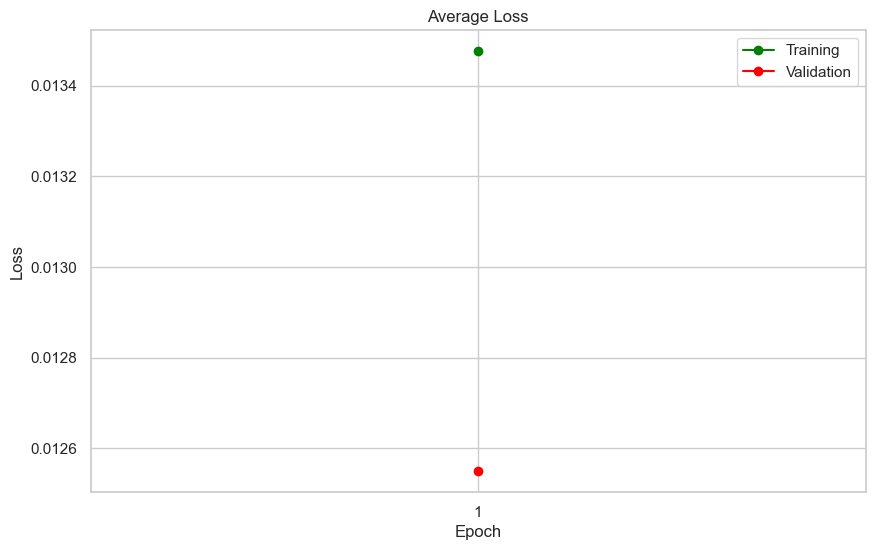

In [10]:
plot_metrics(t_acc, v_acc, 'Accuracy')
plot_metrics(t_loss, v_loss, 'Loss')

In [11]:
def save(model, attributes):
    torch.save({
        'model': model,
        'optimizer_state_dict': attributes['optimizer'].state_dict(),
        'metadata': attributes
    }, 'model/model.pth')
    
save(mb_model, model_attributes)

In [15]:
checkpoint = torch.load('model/model.pth')
loaded_model = checkpoint['model']

optimizer = optim.SGD(loaded_model.parameters(), lr=0.01)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

metadata = checkpoint['metadata']


{'criterion': CrossEntropyLoss(), 'optimizer': Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.001
    lr: 0.001
    maximize: False
    weight_decay: 0
), 'scheduler': <torch.optim.lr_scheduler.StepLR object at 0x28e968a90>, 'batch_size': 128}
None
